In [1]:
import sys
sys.path.append("./src")

import torch
import torch.nn as nn
import numpy as np

from VPINN import *
from train import train

torch.manual_seed(147)
np.random.seed(137)

# Model for the approximation of u

In [2]:
class MLP(nn.Module):
    
    def __init__(self, layers, activation, bias = True, datas = None):
        
        super().__init__()
        
        self.activation = activation
        self.lin1 = nn.Linear(1, 5, dtype=torch.double)
        self.lin2 = nn.Linear(5, 1, bias = False, dtype=torch.double)
        self.linears = [self.lin1, self.lin2]
        for lin in self.linears:
            for n, p in lin.named_parameters():
                if 'weight' in n:
                    nn.init.xavier_normal_(p)
                elif 'bias' in n:
                    nn.init.zeros_(p)
        
    def forward(self, x):
        
        for i, lin in enumerate(self.linears):
            x = lin(x)
            if i < len(self.linears)-1:
                x = self.activation(x)
                
        return x

# VPINN

In [3]:
# Problem Parameters

a, b = -1, 1
A, w = 1, 2.1*np.pi
u_ex = lambda x: A*torch.sin(w*x)
u_left = A*torch.sin(torch.tensor([a*w], dtype = torch.double))
u_right = A*torch.sin(torch.tensor([b*w], dtype = torch.double))
source = lambda x: 0.5 * A**2 * w * torch.sin(2*w*x) + A * w**2 * torch.sin(w*x)

# Model Parameters
method = 1
num_points = 80
num_sine_test_functions = 5
num_poly_test_functions = 10
boundary_penalty = 5
layers = [1, 5, 1]
activation = torch.sin

Loss Interior = 1.596500e+02, Loss Boundary = 3.709564e+00: 100%|██████████| 1000/1000 [00:21<00:00, 45.95it/s]


Training Over


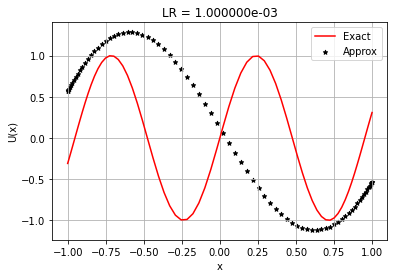

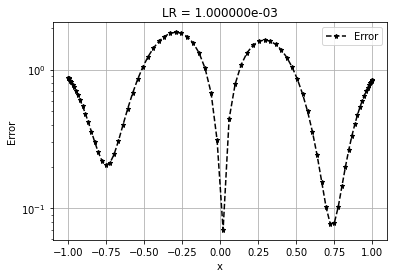

Loss Interior = 1.080339e+02, Loss Boundary = 3.103837e+01: 100%|██████████| 1000/1000 [00:23<00:00, 42.83it/s]


Training Over


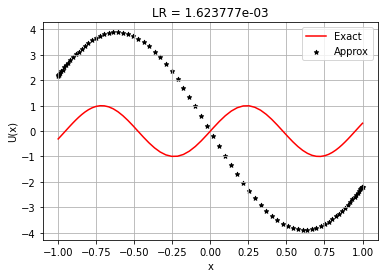

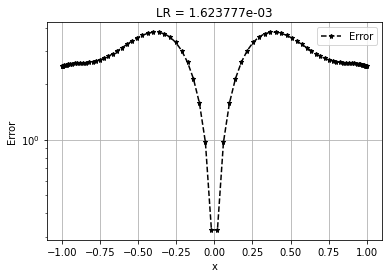

Loss Interior = 1.027561e+02, Loss Boundary = 3.816559e+01: 100%|██████████| 1000/1000 [00:25<00:00, 39.98it/s]


Training Over


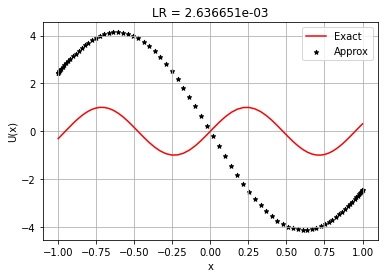

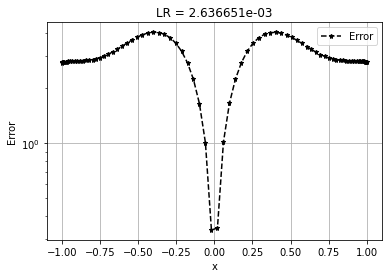

Loss Interior = 1.112892e+02, Loss Boundary = 2.670363e+01: 100%|██████████| 1000/1000 [00:22<00:00, 43.93it/s]


Training Over


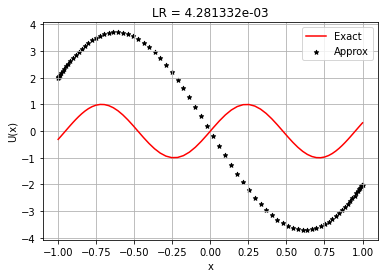

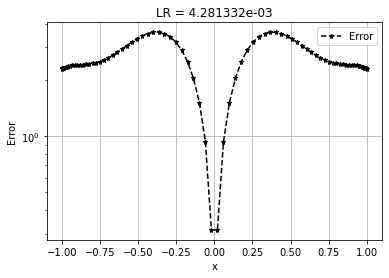

Loss Interior = 1.165735e+02, Loss Boundary = 1.997887e+01: 100%|██████████| 1000/1000 [00:23<00:00, 41.82it/s]


Training Over


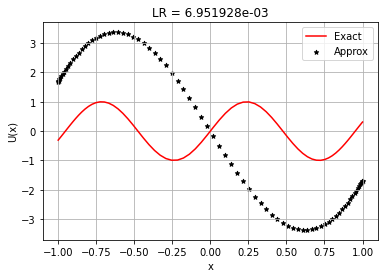

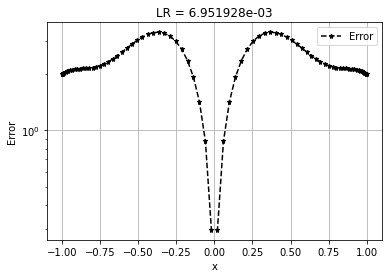

Loss Interior = 1.190249e+02, Loss Boundary = 1.698613e+01: 100%|██████████| 1000/1000 [00:22<00:00, 44.11it/s]


Training Over


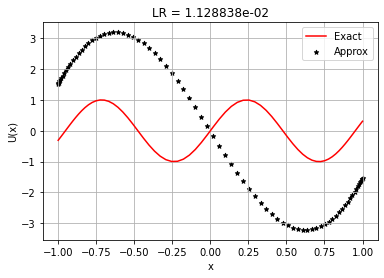

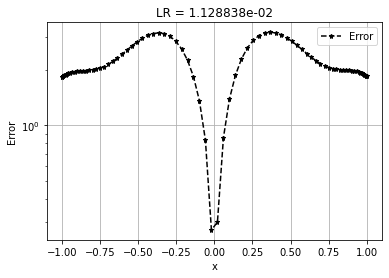

Loss Interior = 1.212582e+02, Loss Boundary = 1.415896e+01: 100%|██████████| 1000/1000 [00:23<00:00, 43.19it/s]


Training Over


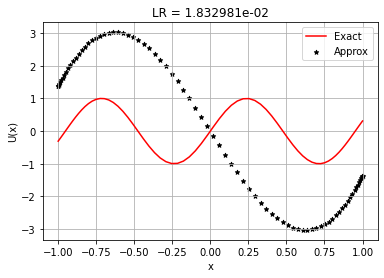

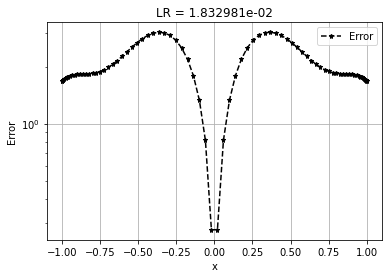

Loss Interior = 1.189956e+02, Loss Boundary = 1.657698e+01: 100%|██████████| 1000/1000 [00:21<00:00, 45.70it/s]


Training Over


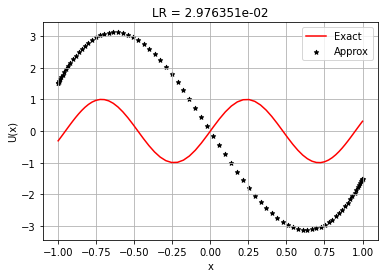

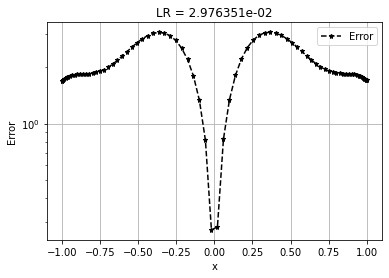

Loss Interior = 1.209798e+02, Loss Boundary = 1.462437e+01: 100%|██████████| 1000/1000 [00:23<00:00, 42.04it/s]


Training Over


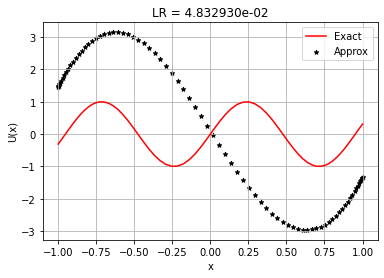

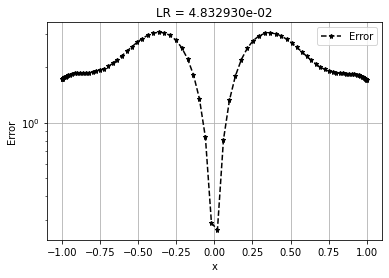

Loss Interior = 1.213439e+02, Loss Boundary = 1.403390e+01: 100%|██████████| 1000/1000 [00:21<00:00, 47.25it/s]


Training Over


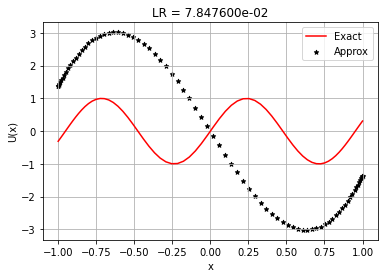

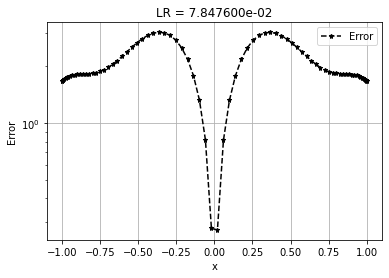

Loss Interior = 1.209788e+02, Loss Boundary = 1.449192e+01: 100%|██████████| 1000/1000 [00:20<00:00, 48.31it/s]


Training Over


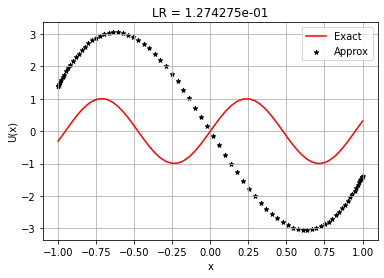

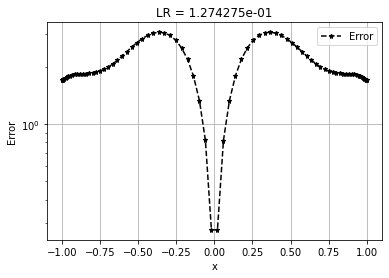

Loss Interior = 1.225415e+02, Loss Boundary = 1.367272e+01: 100%|██████████| 1000/1000 [00:22<00:00, 44.46it/s]


Training Over


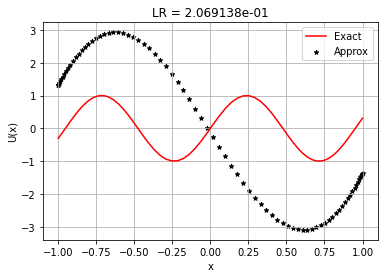

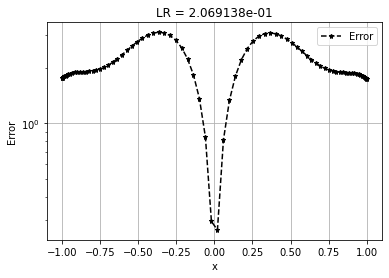

Loss Interior = 1.275622e+02, Loss Boundary = 9.908561e+00: 100%|██████████| 1000/1000 [00:22<00:00, 44.51it/s]


Training Over


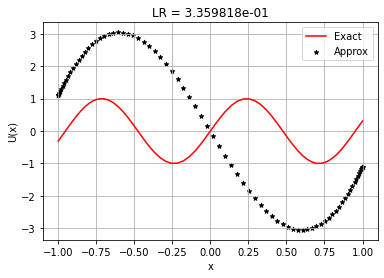

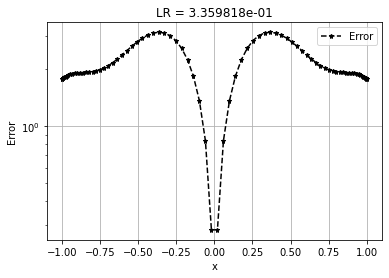

Loss Interior = 1.305226e+02, Loss Boundary = 1.755267e+01: 100%|██████████| 1000/1000 [00:19<00:00, 50.83it/s]


Training Over


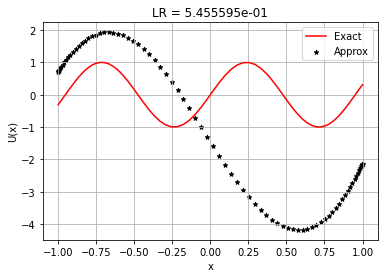

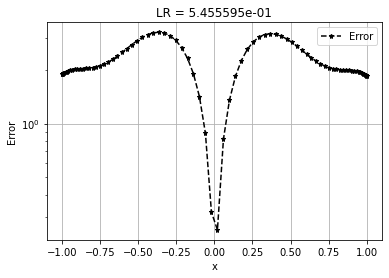

Loss Interior = 1.849434e-01, Loss Boundary = 6.098697e-03: 100%|██████████| 1000/1000 [00:20<00:00, 49.67it/s]


Training Over


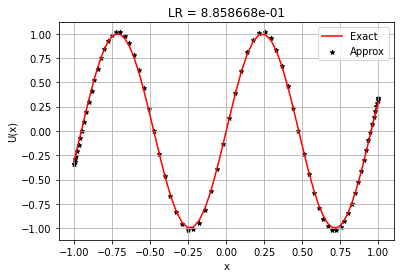

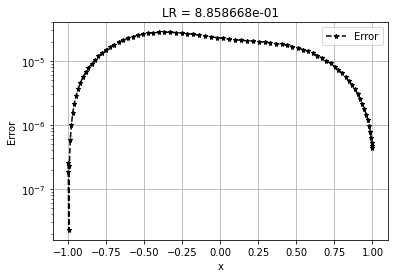

Loss Interior = 9.413211e-26, Loss Boundary = 3.796425e-26: 100%|██████████| 1000/1000 [00:20<00:00, 49.28it/s]


Training Over


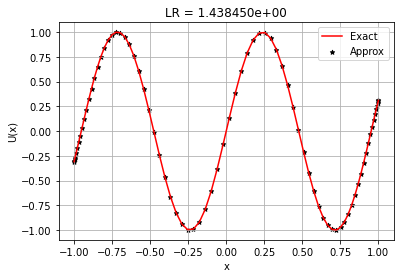

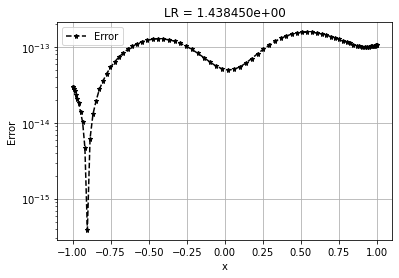

Loss Interior = 9.108218e-01, Loss Boundary = 1.374267e-01: 100%|██████████| 1000/1000 [00:21<00:00, 47.41it/s]


Training Over


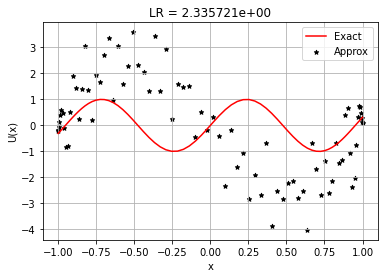

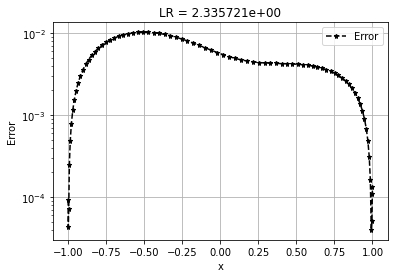

Loss Interior = 5.868764e-01, Loss Boundary = 2.898837e-01: 100%|██████████| 1000/1000 [00:23<00:00, 41.92it/s]


Training Over


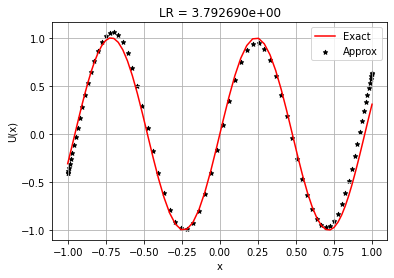

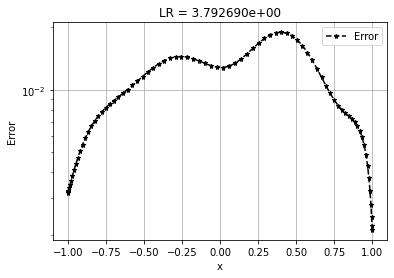

Loss Interior = 3.112533e-01, Loss Boundary = 1.447751e-02: 100%|██████████| 1000/1000 [00:23<00:00, 43.10it/s]


Training Over


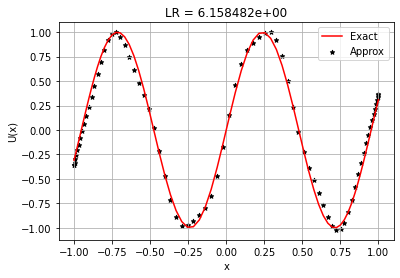

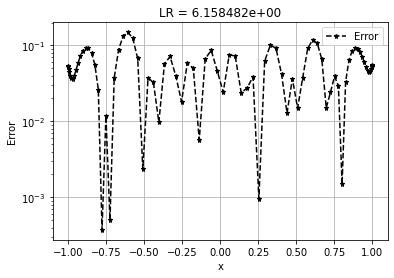

Loss Interior = 1.548964e-02, Loss Boundary = 1.013337e-03: 100%|██████████| 1000/1000 [00:23<00:00, 42.44it/s]


Training Over


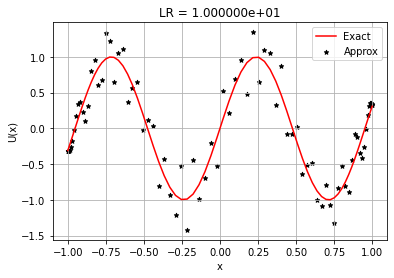

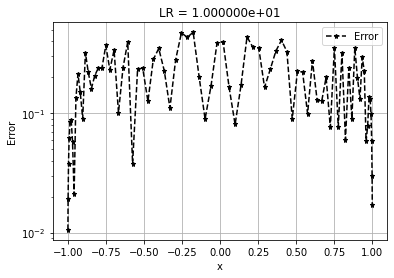

In [4]:
# Optimization Parameters
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_iter = 1000
lr = 1

for lr in np.logspace(-3, 1, 20):
    u_approx = MLP(layers, activation, bias = True, datas = None)
    vpinn = VPINN_SteadyBurger_Dirichlet(a, b, u_left, u_right, source,
                                        num_points, num_sine_test_functions, num_poly_test_functions, 
                                        boundary_penalty, u_approx, u_ex, device =  device)

    optimizer = torch.optim.Adam(vpinn.parameters(), lr = lr)

    # train will only keep the model which returned the best loss
    train(vpinn, optimizer, num_iter, 1, tol = 1e-32, save_gradients=False)
    vpinn.plot()
    plt.title("LR = {:e}".format(lr))
    plt.show()
    vpinn.compute_error()
    vpinn.plot_error()
    plt.title("LR = {:e}".format(lr))
    plt.show()